In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
from time import gmtime, strftime

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
from sklearn import metrics

# to balance the dataset 
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

2024-01-18 11:41:52.633143: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 11:41:52.979246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 11:41:52.979314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 11:41:53.048042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 11:41:53.202136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 11:41:53.204396: I tensorflow/core/platform/cpu_feature_guard.cc:1

Thu 18 Jan 2024 11:41:55 AM -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [2]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df.head(100)

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,2,0.80,0.86,5,262,6,0,1,0,7,2
2,3,0.11,0.88,7,272,4,0,1,0,7,2
3,4,0.72,0.87,5,223,5,0,1,0,7,1
4,5,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.37,0.51,2,155,3,0,1,0,7,1
96,97,0.10,0.77,6,265,4,0,1,0,7,1
97,98,0.10,0.84,6,279,4,0,1,0,7,1
98,99,0.11,0.97,6,284,4,0,1,0,7,1


In [3]:
print(df['turnover'].value_counts(normalize=True).map('{:.2%}'.format))

turnover
0    76.19%
1    23.81%
Name: proportion, dtype: object


In [4]:
df.promotion.min()

0

In [5]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [6]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover', 'Emp ID'])
y = df['turnover']

In [7]:
# Method of inertia to find the ideal of clusters.
inertia = [] # list 

for k in range(1, 11):
    clf = KMeans(n_clusters = k , random_state= 123)
    clf.fit(X)
    inertia.append(clf.inertia_)

In [8]:
pd.DataFrame({"k":list(range(1 , 11)),
              "inércia": inertia})

,k,inércia
0,1,3.759731e+07
1,2,8.982092e+06
2,3,4.520220e+06
3,4,2.913593e+06
4,5,2.098098e+06
5,6,1.565807e+06
6,7,1.251906e+06
7,8,9.824961e+05
8,9,7.879043e+05
9,10,6.726219e+05


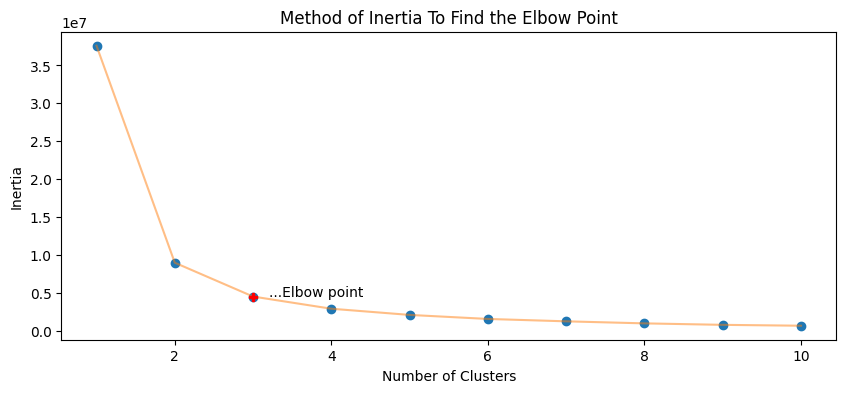

In [9]:
plt.figure(1 , figsize = (10 ,4))
plt.title('Method of Inertia To Find the Elbow Point')
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# adicionado depois... ;-)
plt.plot(3 , inertia[2] , 'P', alpha = 1, color = 'red')
plt.text(3 + 0.2 , inertia[2] , '...Elbow point')

plt.show()

In [10]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

In [11]:
len(kmeans.labels_)

3571

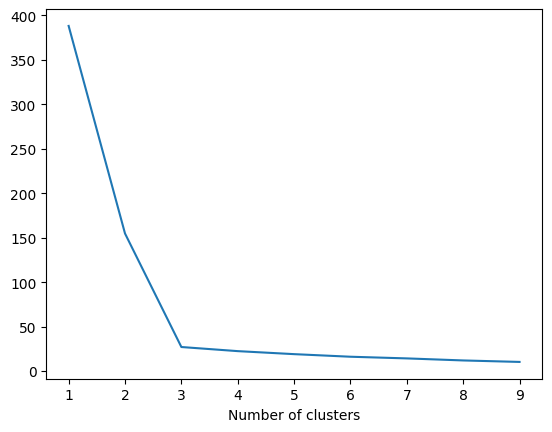

In [12]:
# Determine number of clusters with K-means elbow method
# The arc of the elbow shows that number 3 is our best fit and as thus we would create  3 clusters of employee
sse={}
br = df[df.turnover==1][["satisfaction","evaluation"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[df.turnover==1][["satisfaction","evaluation"]])

    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [13]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=df["satisfaction"], y=df["evaluation"],
    mode='markers',
    marker=dict(
        color= kmeans_colors,
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100],
    )
)])
fig.update_layout(title_text='Employee Cluster Chart')
fig.show()

### Train and Test features

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y, shuffle = True)

In [15]:
# preprocessing technique used to address a class imbalance in a dataset.
#sm = SMOTE(random_state=42)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [16]:
print(y_train.value_counts(normalize=True).map('{:.2%}'.format))

turnover
0    76.19%
1    23.81%
Name: proportion, dtype: object


### Modeling

In [17]:
modelname = 'model'

def metric_models(modelname, model, X_test, y_test, y_pred):

    acc   = round(accuracy_score(y_test,y_pred), 4)*100
    score = round(metrics.precision_score(y_test, y_pred, average='macro'), 4)*100
    mae   = round(mean_absolute_error(y_test, y_pred), 5)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    auc = round((metrics.roc_auc_score(y_test, y_pred_proba)), 4)*100

    print(f'{modelname} model:')
    print(f"accuracy........:{acc}%")
    print(f'score...........:{score}')
    print(f"Mean Absolute Error: {mae}")
    print(f"Area under curve (AUC): {auc} %")

In [18]:
def plot_conf_matrix(y_test, y_pred):
    confusion_matrix1 = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.grid(False)
    plt.show()

#### Logistic Regression V.S. Random Forest V.S. Decision Tree V.S. AdaBoost Model


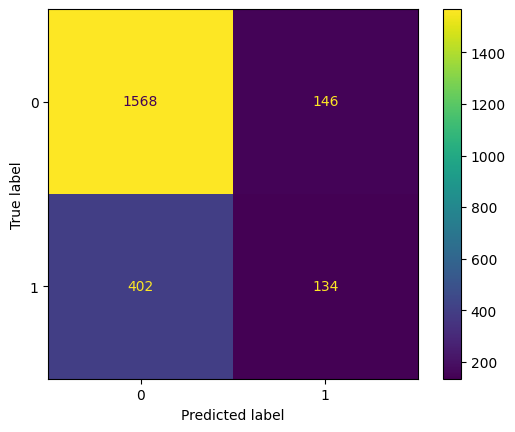

In [19]:
logreg_model = LogisticRegression(penalty='l2', C=1)

logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

plot_conf_matrix(y_test, y_pred_logreg)

In [20]:
logreg_model.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [21]:
metric_models('LogisticRegression', logreg_model, X_test, y_test, y_pred_logreg)

LogisticRegression model:
accuracy........:75.64%
score...........:63.73
Mean Absolute Error: 0.24356
Area under curve (AUC): 79.02 %


In [22]:
# Using 10 fold Cross-Validation to train our Logistic Regression Model
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression(class_weight = "balanced")
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.817 (0.013)


In [23]:
# NOTE: By adding in "class_weight = balanced", the Logistic Auc increased by about 10%! This adjusts the threshold value
logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(y_test, logis.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, logis.predict(X_test)))



 ---Logistic Model---
Logistic AUC = 0.75
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1714
           1       0.48      0.76      0.59       536

    accuracy                           0.75      2250
   macro avg       0.69      0.75      0.70      2250
weighted avg       0.81      0.75      0.76      2250



In [24]:
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# predict the results
y_pred_lgb=lgb_model.predict(X_test)

print ("\n\n ---LGBMClassifier Model---")
lgb_roc_auc = roc_auc_score(y_test, y_pred_lgb)
print ("LGBMClassifier AUC = %2.2f" % lgb_roc_auc)
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 3035, number of negative: 9714


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 12749, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238058 -> initscore=-1.163357
[LightGBM] [Info] Start training from score -1.163357


 ---LGBMClassifier Model---
LGBMClassifier AUC = 0.97
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1714
           1       0.98      0.95      0.97       536

    accuracy                           0.98      2250
   macro avg       0.98      0.97      0.98      2250
weighted avg       0.98      0.98      0.98      2250



In [25]:
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [26]:
metric_models('LightGBMClassifier', lgb_model, X_test, y_test, y_pred_lgb)

LightGBMClassifier model:
accuracy........:98.4%
score...........:98.22
Mean Absolute Error: 0.016
Area under curve (AUC): 99.6 %


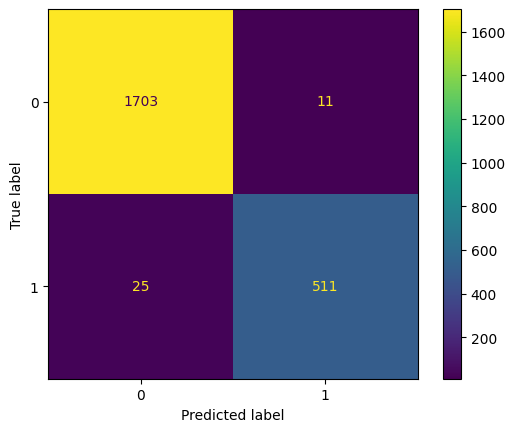

In [27]:
plot_conf_matrix(y_test, y_pred_lgb)

In [28]:
# Decision Tree Model
dtree_model = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree_model.fit(X_train,y_train)
y_pred_dtree = dtree_model.predict(X_test)

print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, y_pred_dtree)
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, y_pred_dtree))



 ---Decision Tree Model---
Decision Tree AUC = 0.94
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1714
           1       0.92      0.91      0.92       536

    accuracy                           0.96      2250
   macro avg       0.95      0.94      0.94      2250
weighted avg       0.96      0.96      0.96      2250



In [29]:
metric_models('Decision Tree', dtree_model, X_test, y_test, y_pred_dtree)

Decision Tree model:
accuracy........:96.0%
score...........:94.59
Mean Absolute Error: 0.04
Area under curve (AUC): 97.64 %


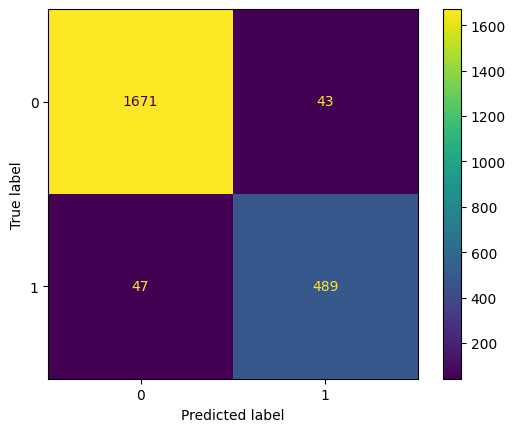

In [30]:
plot_conf_matrix(y_test, y_pred_dtree)

In [31]:
# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced",
    n_jobs=-1
    #min_weight_fraction_leaf=0.02 
    )
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, y_pred_rf))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1714
           1       0.99      0.96      0.98       536

    accuracy                           0.99      2250
   macro avg       0.99      0.98      0.98      2250
weighted avg       0.99      0.99      0.99      2250



In [32]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
metric_models('Random Forest', rf_model, X_test, y_test, y_pred_rf)

Random Forest model:
accuracy........:98.83999999999999%
score...........:98.91
Mean Absolute Error: 0.01156
Area under curve (AUC): 99.5 %


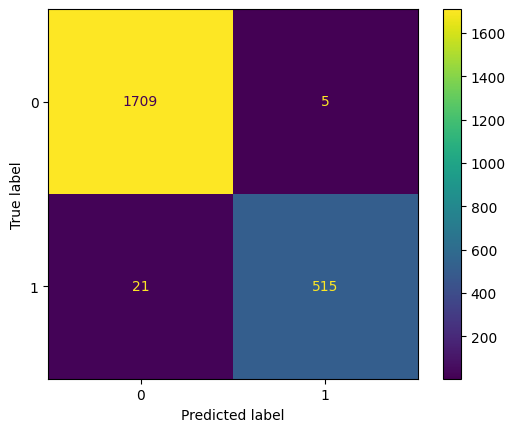

In [34]:
plot_conf_matrix(y_test, y_pred_rf)

In [35]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, rf_model.feature_importances_):
    importance = round(importance*100, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 29.23 %
2 - feature: evaluation, importance: 12.74 %
3 - feature: projectCount, importance: 15.18 %
4 - feature: averageMonthlyHours, importance: 14.77 %
5 - feature: yearsAtCompany, importance: 25.5 %
6 - feature: workAccident, importance: 0.73 %
7 - feature: promotion, importance: 0.11 %
8 - feature: dept, importance: 1.11 %
9 - feature: salary, importance: 0.62 %


In [36]:
list_feat_importances = list(rf_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 29.23 %
evaluation.......: 12.74 %
projectCount.......: 15.18 %
averageMonthlyHours.......: 14.77 %
yearsAtCompany.......: 25.5 %
workAccident.......: 0.73 %
promotion.......: 0.11 %
dept.......: 1.11 %
salary.......: 0.62 %


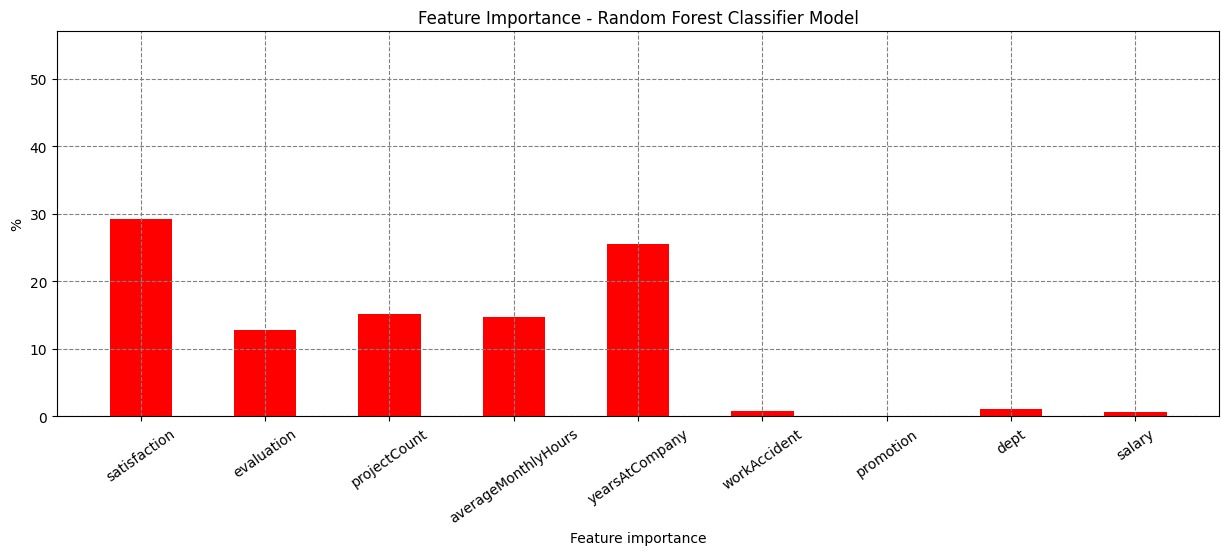

In [37]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,57)
plt.title("Feature Importance - Random Forest Classifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [38]:
# Ada Boost
ada_model = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada_model.fit(X_train,y_train)
y_pred_ada = ada_model.predict(X_test)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, y_pred_ada)
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, y_pred_ada))



 ---AdaBoost Model---
AdaBoost AUC = 0.92
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1714
           1       0.91      0.88      0.89       536

    accuracy                           0.95      2250
   macro avg       0.94      0.92      0.93      2250
weighted avg       0.95      0.95      0.95      2250



In [39]:
metric_models('AdaBoost', ada_model, X_test, y_test, y_pred_ada)

AdaBoost model:
accuracy........:94.98%
score...........:93.55
Mean Absolute Error: 0.05022
Area under curve (AUC): 97.55 %


In [40]:
list_feat_importances = list(ada_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 31.25 %
evaluation.......: 15.0 %
projectCount.......: 11.5 %
averageMonthlyHours.......: 17.0 %
yearsAtCompany.......: 13.25 %
workAccident.......: 4.0 %
promotion.......: 0.0 %
dept.......: 2.0 %
salary.......: 6.0 %


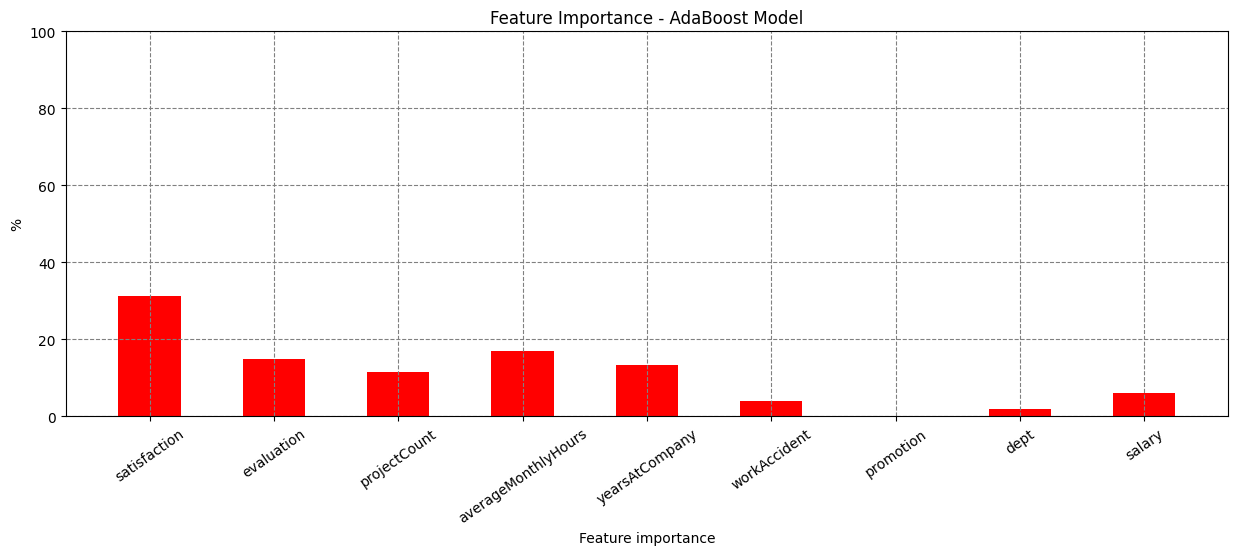

In [41]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - AdaBoost Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [42]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print ("\n\n ---XGBClassifier Model---")
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
print ("XGBClassifier AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, y_pred_xgb))



 ---XGBClassifier Model---
XGBClassifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1714
           1       0.98      0.97      0.97       536

    accuracy                           0.99      2250
   macro avg       0.99      0.98      0.98      2250
weighted avg       0.99      0.99      0.99      2250



In [43]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [44]:
metric_models('XGBClassifier', xgb_model, X_test, y_test, y_pred_xgb)

XGBClassifier model:
accuracy........:98.76%
score...........:98.53
Mean Absolute Error: 0.01244
Area under curve (AUC): 99.53 %


In [45]:
list_feat_importances = list(xgb_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 29.16 %
evaluation.......: 9.45 %
projectCount.......: 15.77 %
averageMonthlyHours.......: 4.38 %
yearsAtCompany.......: 30.11 %
workAccident.......: 5.75 %
promotion.......: 1.38 %
dept.......: 1.66 %
salary.......: 2.35 %


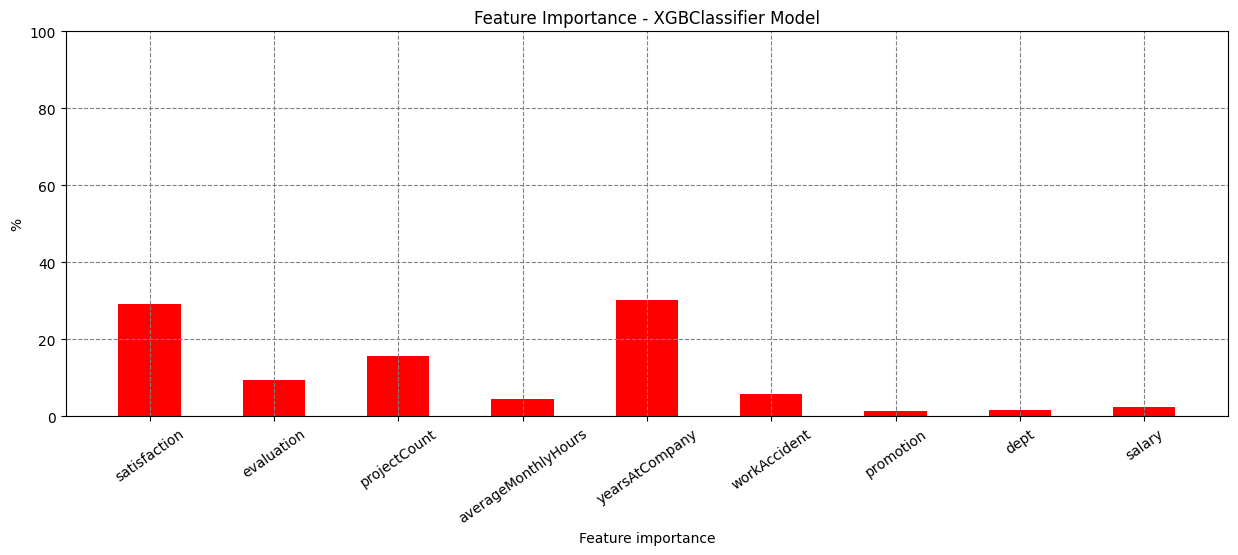

In [46]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - XGBClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [47]:
# Create CatBoost classifier
#cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy')

from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(
    iterations = 300, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 10,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
y_pred_cat = cat_model.predict(X_test)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, y_pred_cat)
print ("CatBoost AUC = %2.2f" % cat_roc_auc)
print(classification_report(y_test, y_pred_cat))



 ---CatBoostClassifier Model---
CatBoost AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1714
           1       0.98      0.98      0.98       536

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [48]:
cat_model.get_params()

{'iterations': 300,
 'learning_rate': 0.1,
 'depth': 10,
 'l2_leaf_reg': 5,
 'loss_function': 'MultiClass',
 'leaf_estimation_iterations': 100,
 'random_strength': 0.5,
 'eval_metric': 'MultiClass',
 'bagging_temperature': 0.5,
 'bootstrap_type': 'Bayesian'}

In [49]:
metric_models('CatBoostClassifier', cat_model, X_test, y_test, y_pred_cat)

CatBoostClassifier model:
accuracy........:98.92999999999999%
score...........:98.53
Mean Absolute Error: 0.01067
Area under curve (AUC): 99.26 %


In [50]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}

i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 20.18 %
evaluation.......: 15.15 %
projectCount.......: 13.67 %
averageMonthlyHours.......: 13.58 %
yearsAtCompany.......: 16.84 %
workAccident.......: 2.46 %
promotion.......: 0.12 %
dept.......: 10.97 %
salary.......: 7.04 %


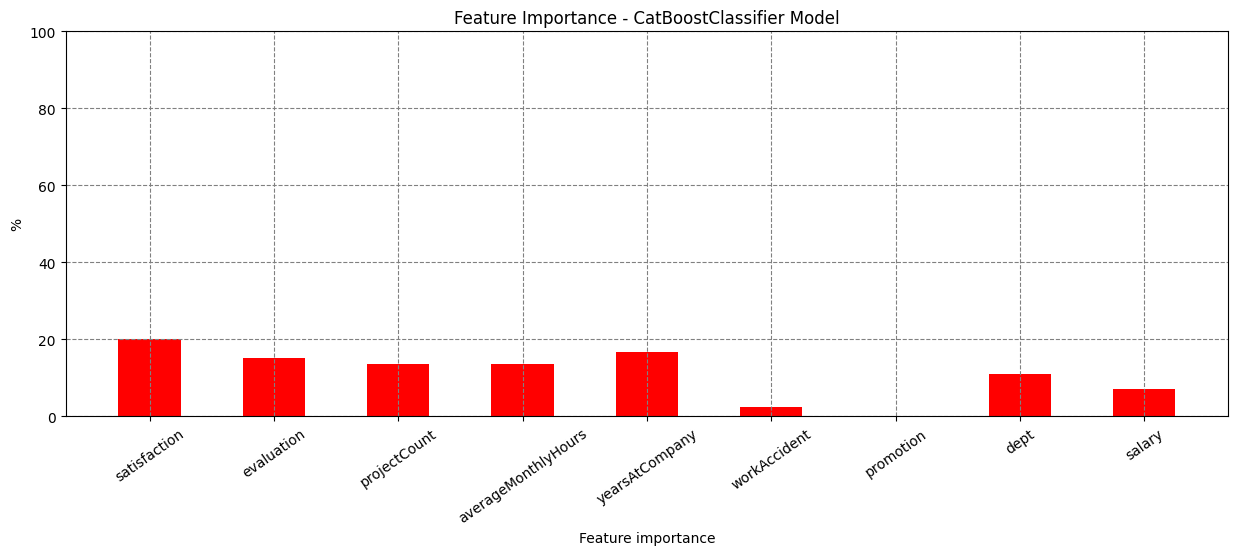

In [51]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - CatBoostClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

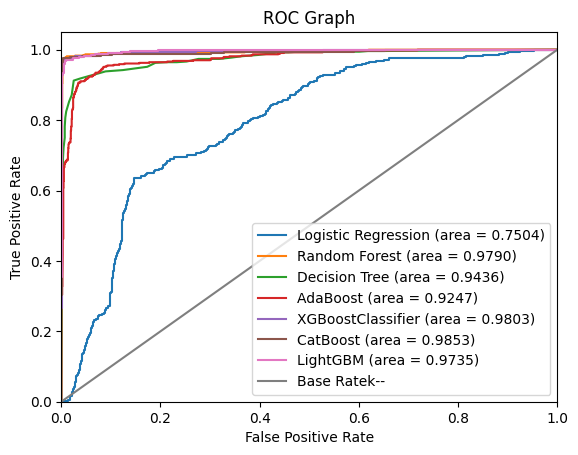

In [52]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree_model.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
cat_fpr, cat_tpr, cat_thresholds = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(y_test, lgb_model.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.4f)' % rf_roc_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.4f)' % dt_roc_auc)
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.4f)' % ada_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoostClassifier (area = %0.4f)' % xgb_roc_auc)
plt.plot(cat_fpr, cat_tpr, label='CatBoost (area = %0.4f)' % cat_roc_auc)
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM (area = %0.4f)' % lgb_roc_auc)
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

# Save the plot as a PNG file
plt.savefig('../images/roc_curve_models.png')

plt.show()

In [53]:
os.system('date')

Thu 18 Jan 2024 11:42:55 AM -03


0